'Author':  [Rubel Ahmod](https://www.kaggle.com/rubelahmod)\
'Date': 7.2.25\
'Dataset':  [heart disease](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
# from xgboost import XGBClassifier


#metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error

# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('heart_desease.csv')
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [10]:
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [11]:
df.shape

(920, 16)

In [12]:
# Select only numerical columns for analysis
numeric_columns = df.select_dtypes(include='number').columns

def quartile_ranges(df):
    
    # Initialize a dictionary to store results
    quartile_ranges_dict = {}

    # Iterate over numerical columns
    for column in numeric_columns:
        # Calculate quartile values
        q1 = df[column].describe()['25%']
        q2 = df[column].describe()['50%']
        q3 = df[column].describe()['75%']

        # Count observations in each quartile range
        min_to_q1 = df[(df[column] >= df[column].min()) & (df[column] <= q1)].shape[0]
        q1_to_q2 = df[(df[column] > q1) & (df[column] <= q2)].shape[0]
        q2_to_q3 = df[(df[column] > q2) & (df[column] <= q3)].shape[0]
        q3_to_max = df[(df[column] > q3) & (df[column] <= df[column].max())].shape[0]

        # Store results in the dictionary
        quartile_ranges_dict[column] = {
            'In Q_1': min_to_q1,
            'In Q_2': q1_to_q2,
            'In Q_3': q2_to_q3,
            'In Q_4': q3_to_max
        }

    return quartile_ranges_dict
print('Number of Observations in each Quartile\n')
for col in numeric_columns:
    print("For '"+ col+ "':", quartile_ranges(df)[col], "\n")

Number of Observations in each Quartile

For 'id': {'In Q_1': 230, 'In Q_2': 230, 'In Q_3': 230, 'In Q_4': 230} 

For 'age': {'In Q_1': 239, 'In Q_2': 233, 'In Q_3': 227, 'In Q_4': 221} 

For 'trestbps': {'In Q_1': 293, 'In Q_2': 195, 'In Q_3': 164, 'In Q_4': 209} 

For 'chol': {'In Q_1': 224, 'In Q_2': 223, 'In Q_3': 222, 'In Q_4': 221} 

For 'thalch': {'In Q_1': 243, 'In Q_2': 219, 'In Q_3': 188, 'In Q_4': 215} 

For 'oldpeak': {'In Q_1': 382, 'In Q_2': 57, 'In Q_3': 210, 'In Q_4': 209} 

For 'ca': {'In Q_1': 181, 'In Q_2': 0, 'In Q_3': 67, 'In Q_4': 61} 

For 'num': {'In Q_1': 411, 'In Q_2': 265, 'In Q_3': 109, 'In Q_4': 135} 



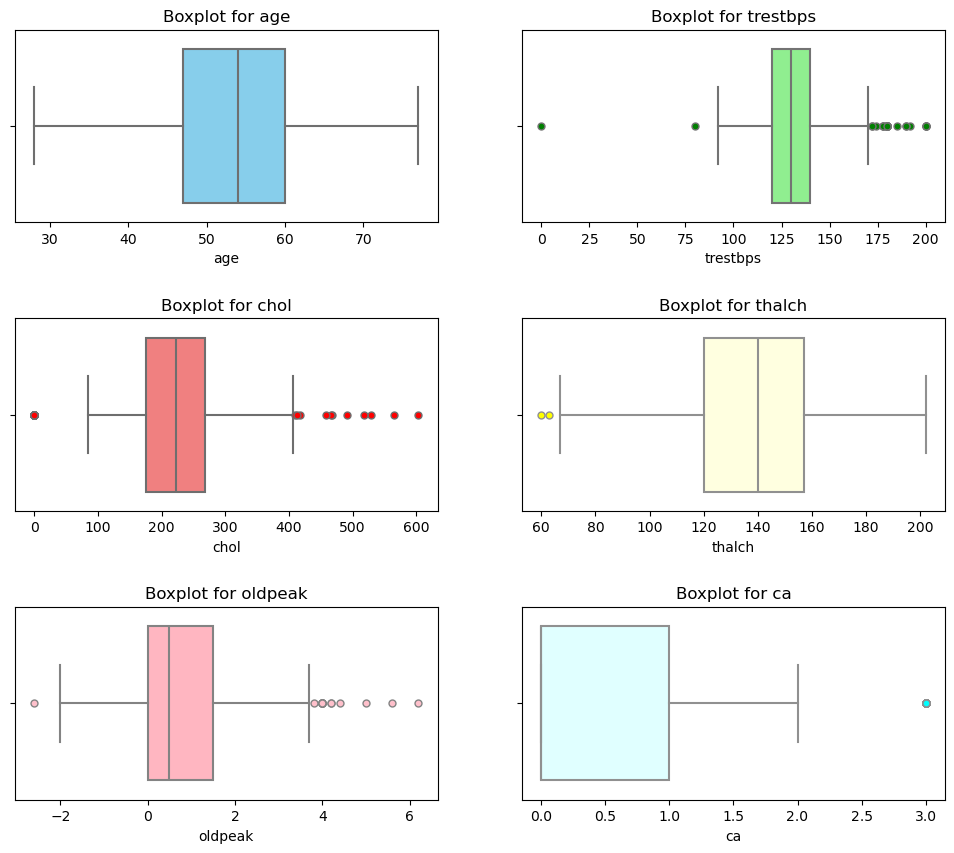

In [13]:
boxplot_columns = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.5)

# Define custom colors for boxes and outliers
box_colors = ["skyblue", "lightgreen", "lightcoral", "lightyellow", "lightpink", "lightcyan"]
outlier_colors = ["blue", "green", "red", "yellow", "pink", "cyan"]

# Plot boxplots for each numeric column with custom colors
for i, column in enumerate(boxplot_columns):
    row = i // 2
    col = i % 2
    sns.boxplot(x=df[column], ax=axes[row, col], color=box_colors[i], boxprops=dict(facecolor=box_colors[i]),
                flierprops=dict(markerfacecolor=outlier_colors[i], marker="o")).set(title=f'Boxplot for {column}')


plt.show()

In [14]:
df['age'].min(), df['age'].max()

(28, 77)

In [15]:
df.age.describe()

count    920.000000
mean      53.510870
std        9.424685
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: age, dtype: float64

### Outputs:
1. The minimum  age to have a heart desease starts from 28 years old
2. most of the people get heart desease at the age of 53-54 years

<Axes: xlabel='age', ylabel='Count'>

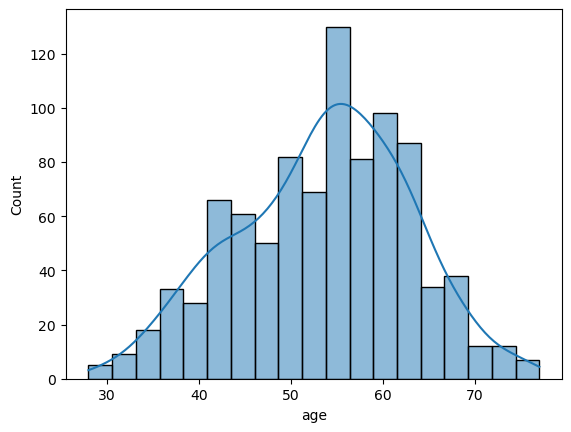

In [16]:
sns.histplot(df['age'], kde=True)

Mean: 53.51086956521739
Median: 54.0
Mode: 54


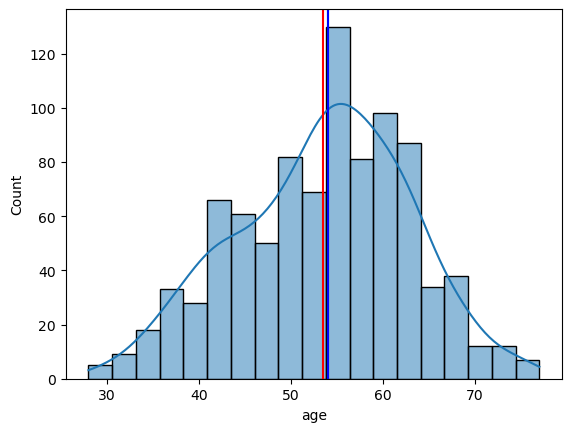

In [17]:
# plot the mean, median and mode of age column using sns
sns.histplot(df['age'], kde=True)
plt.axvline(df['age'].mean(), color='red')    #'axvline' means add vertical line tot the plot
plt.axvline(df['age'].median(), color='green')
plt.axvline(df['age'].mode()[0], color='blue')

# print the value of mean, median and mode of age column
print('Mean:', df['age'].mean())
print('Median:', df['age'].median())
print('Mode:', df['age'].mode()[0])

In [18]:
df.columns

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

In [19]:
import plotly.express as px
fig = px.histogram(data_frame=df, x='age', color='sex')
fig.show()

In [20]:
df.columns

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

### Let's explore the gender/sex based distribution of the dataset for age column

In [21]:
df.sex.value_counts()

sex
Male      726
Female    194
Name: count, dtype: int64

In [22]:
df.sex.value_counts().sum()

920

In [23]:
df.groupby('sex')['age'].value_counts()

sex     age
Female  54     15
        51     11
        62     10
        48      9
        43      9
               ..
Male    77      2
        76      1
        33      1
        28      1
        31      1
Name: count, Length: 91, dtype: int64

In [24]:
df.groupby('sex')['age'].value_counts().sum()

920

In [25]:
# calculate the percentages of male and female value counts in the data
male_count = 726
female_count = 194
total_count = male_count + female_count

# calculate percentages
male_percentage = (male_count / total_count) * 100
female_percentage = (female_count / total_count) * 100

# display the results
print(f"Male percentage in the data: {male_percentage:.2f}%")
print(f"Female Percentage in the data: {female_percentage:.2f}%")

# difference
difference_percentage = ((male_count - female_count) / female_count) * 100
print(f"Males are {difference_percentage:.2f}% more than females in the data.")

Male percentage in the data: 78.91%
Female Percentage in the data: 21.09%
Males are 274.23% more than females in the data.


In [26]:
df.columns

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

### Deal with dataset column

In [27]:
df['dataset'].unique()

array(['Cleveland', 'Hungary', 'Switzerland', 'VA Long Beach'],
      dtype=object)

In [28]:
df['dataset'].value_counts()

dataset
Cleveland        304
Hungary          293
VA Long Beach    200
Switzerland      123
Name: count, dtype: int64

<Axes: xlabel='dataset', ylabel='count'>

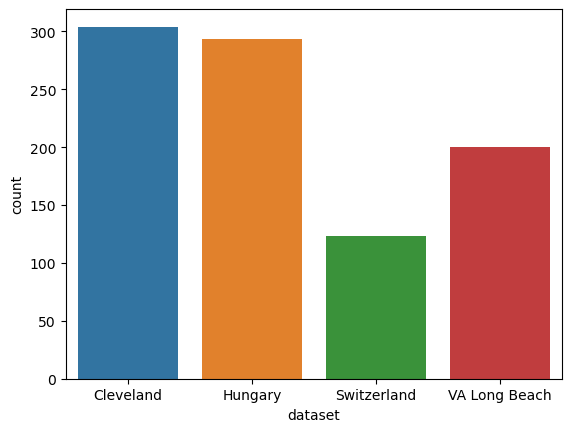

In [29]:
sns.countplot(data=df, x='dataset')

<Axes: xlabel='dataset', ylabel='count'>

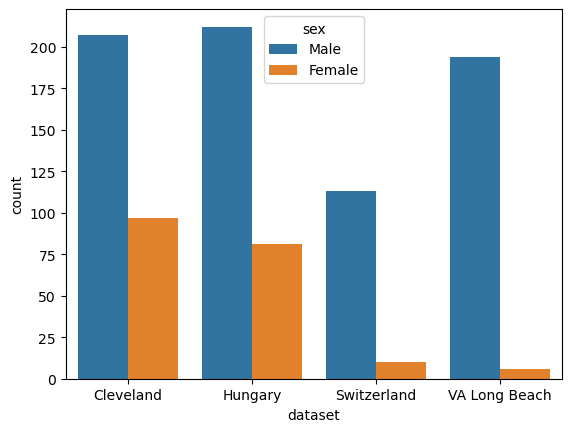

In [30]:
sns.countplot(data=df, x='dataset', hue = 'sex')

In [31]:
fig = px.bar(df, x='dataset', color='sex')
fig.show()

In [32]:
print(df.groupby('sex')['dataset'].value_counts())

sex     dataset      
Female  Cleveland         97
        Hungary           81
        Switzerland       10
        VA Long Beach      6
Male    Hungary          212
        Cleveland        207
        VA Long Beach    194
        Switzerland      113
Name: count, dtype: int64


In [33]:
fig = px.histogram(data_frame=df, x='age', color='dataset')
fig.show()

In [34]:
# print the mean median and mode of age column grouped by dataset column
print(f"Mean of Data Set: {df.groupby('dataset')['age'].mean()}")
print("-------------------------------------")
print(f"Median of Data Set: {df.groupby('dataset')['age'].median()}")
print("-------------------------------------")
print(f"Mode of Data Set: {df.groupby('dataset')['age'].agg(pd.Series.mode)}")
print("-------------------------------------")

Mean of Data Set: dataset
Cleveland        54.351974
Hungary          47.894198
Switzerland      55.317073
VA Long Beach    59.350000
Name: age, dtype: float64
-------------------------------------
Median of Data Set: dataset
Cleveland        55.5
Hungary          49.0
Switzerland      56.0
VA Long Beach    60.0
Name: age, dtype: float64
-------------------------------------
Mode of Data Set: dataset
Cleveland              58
Hungary                54
Switzerland            61
VA Long Beach    [62, 63]
Name: age, dtype: object
-------------------------------------


In [35]:
df.columns

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

### lets explore 'cp' column

In [36]:
df['cp'].value_counts()

cp
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: count, dtype: int64

In [37]:
fig= px.histogram(data_frame=df, x='age', color='cp')
fig.show()

<Axes: xlabel='cp', ylabel='count'>

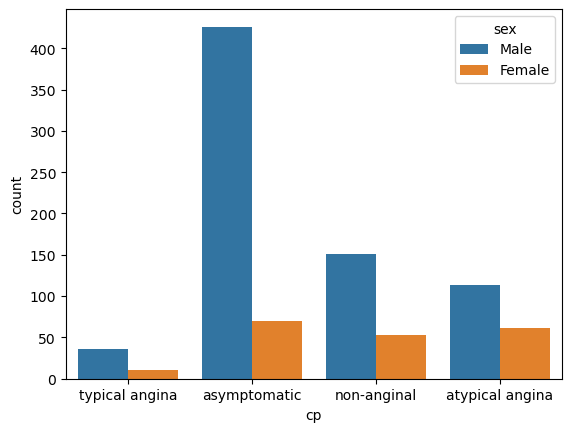

In [38]:
sns.countplot(df, x='cp', hue='sex')

<Axes: xlabel='cp', ylabel='count'>

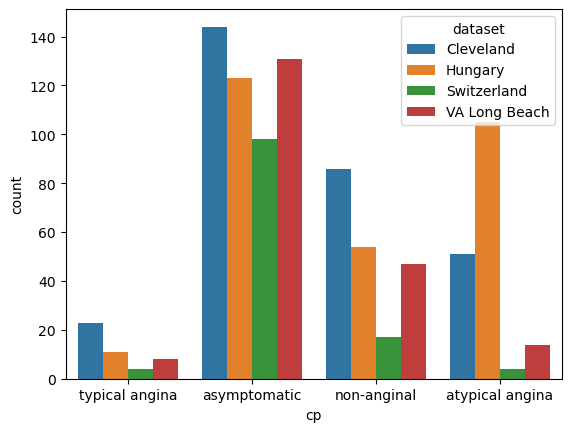

In [39]:
sns.countplot(df, x='cp', hue='dataset')

### let's explore the 'trestbps (resting blood pressure) column

The normal resting blood pressure is 120/80 mm Hg.

In [40]:
df['trestbps'].value_counts() 

trestbps
120.0    131
130.0    115
140.0    102
110.0     59
150.0     56
        ... 
164.0      1
101.0      1
174.0      1
192.0      1
127.0      1
Name: count, Length: 61, dtype: int64

In [41]:
df['trestbps'].describe()

count    861.000000
mean     132.132404
std       19.066070
min        0.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: trestbps, dtype: float64

<Axes: xlabel='trestbps', ylabel='Count'>

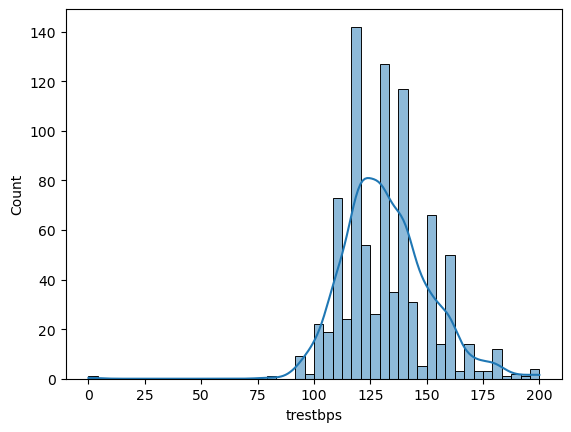

In [42]:
sns.histplot(df['trestbps'], kde=True)

In [43]:
imputer_1 = IterativeImputer(max_iter=10, random_state=42)
imputer_1.fit(df[['trestbps']])
df['trestbps'] = imputer_1.transform(df[['trestbps']])

print(f"Missing values in trestbps column: {df['trestbps'].isnull().sum()}")

Missing values in trestbps column: 0


In [44]:
(df.isnull().sum()/len(df)*100).sort_values(ascending=False)

ca          66.413043
thal        52.826087
slope       33.586957
fbs          9.782609
oldpeak      6.739130
thalch       5.978261
exang        5.978261
chol         3.260870
restecg      0.217391
id           0.000000
age          0.000000
sex          0.000000
dataset      0.000000
cp           0.000000
trestbps     0.000000
num          0.000000
dtype: float64

In [45]:
imputer_2 = IterativeImputer(max_iter=10, random_state=42)
df['ca'] = imputer_2.fit_transform(df[['ca']])
df['oldpeak'] = imputer_2.fit_transform(df[['oldpeak']])
df['thalch'] = imputer_2.fit_transform(df[['thalch']])
df['chol'] = imputer_2.fit_transform(df[['chol']])

In [46]:
(df.isnull().sum()/len(df)*100).sort_values(ascending=False)

thal        52.826087
slope       33.586957
fbs          9.782609
exang        5.978261
restecg      0.217391
id           0.000000
age          0.000000
sex          0.000000
dataset      0.000000
cp           0.000000
trestbps     0.000000
chol         0.000000
thalch       0.000000
oldpeak      0.000000
ca           0.000000
num          0.000000
dtype: float64

### Let's impute the missing values in 'thal' column by using ML models

In [47]:
df['thal'].value_counts()

thal
normal               196
reversable defect    192
fixed defect          46
Name: count, dtype: int64

In [48]:
print(f"The missing values in thal column are: {df['thal'].isnull().sum()}")

The missing values in thal column are: 486


In [49]:
# Map the values in the 'cp' column.
df['cp'] = df['cp'].map({'typical angina': 'typical-angina', 'asymptomatic': 'asymptomatic', 'non-anginal': 'non-anginal', 'atypical angina': 'atypical-angina'})

# Map the values in the 'restecg' column.
df['restecg'] = df['restecg'].map({'lv hypertrophy': 'lv-hypertrophy', 'normal': 'normal', 'st-t abnormality': 'st-t-abnormality'})

# Map the values in the 'thal' column.
df['thal'] = df['thal'].map({'normal': 'normal', 'fixed defect': 'fixed-defect', 'reversable defect': 'reversable-defect'})

# Map the values in the 'dataset' column.
df['dataset'] = df['dataset'].map({'Cleveland': 'Cleveland', 'Hungary': 'Hungary', 'Switzerland': 'Switzerland', 'VA Long Beach': 'VA-Long-Beach'})

In [50]:
# impute the missing value
missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()

classifier_cols = ['thal', 'ca', 'slope', 'exang', 'restecg','fbs', 'cp', 'sex', 'num']
bool_cols = ['fbs', 'exang']
regressor_cols = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']

In [51]:
(df.isnull().sum()/len(df)*100).sort_values(ascending=False)

thal        52.826087
slope       33.586957
fbs          9.782609
exang        5.978261
restecg      0.217391
id           0.000000
age          0.000000
sex          0.000000
dataset      0.000000
cp           0.000000
trestbps     0.000000
chol         0.000000
thalch       0.000000
oldpeak      0.000000
ca           0.000000
num          0.000000
dtype: float64

In [52]:
missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()


classifier_cols = ['thal', 'ca', 'slope', 'exang', 'restecg','fbs', 'cp', 'sex', 'num']
bool_cols = ['fbs', 'exang']
regressor_cols = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']

In [53]:
def impute_categorical_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

In [54]:
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in classifier_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in regressor_cols:
        df[col] = impute_continuous_missing_data(col)
    else:
        pass

Missing Values fbs : 9.78%
The feature 'fbs' has been imputed with 78.92 accuracy

Missing Values restecg : 0.22%
The feature 'restecg' has been imputed with 65.22 accuracy

Missing Values exang : 5.98%
The feature 'exang' has been imputed with 80.35 accuracy

Missing Values slope : 33.59%
The feature 'slope' has been imputed with 69.92 accuracy

Missing Values thal : 52.83%
The feature 'thal' has been imputed with 74.71 accuracy



In [55]:
df.isnull().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

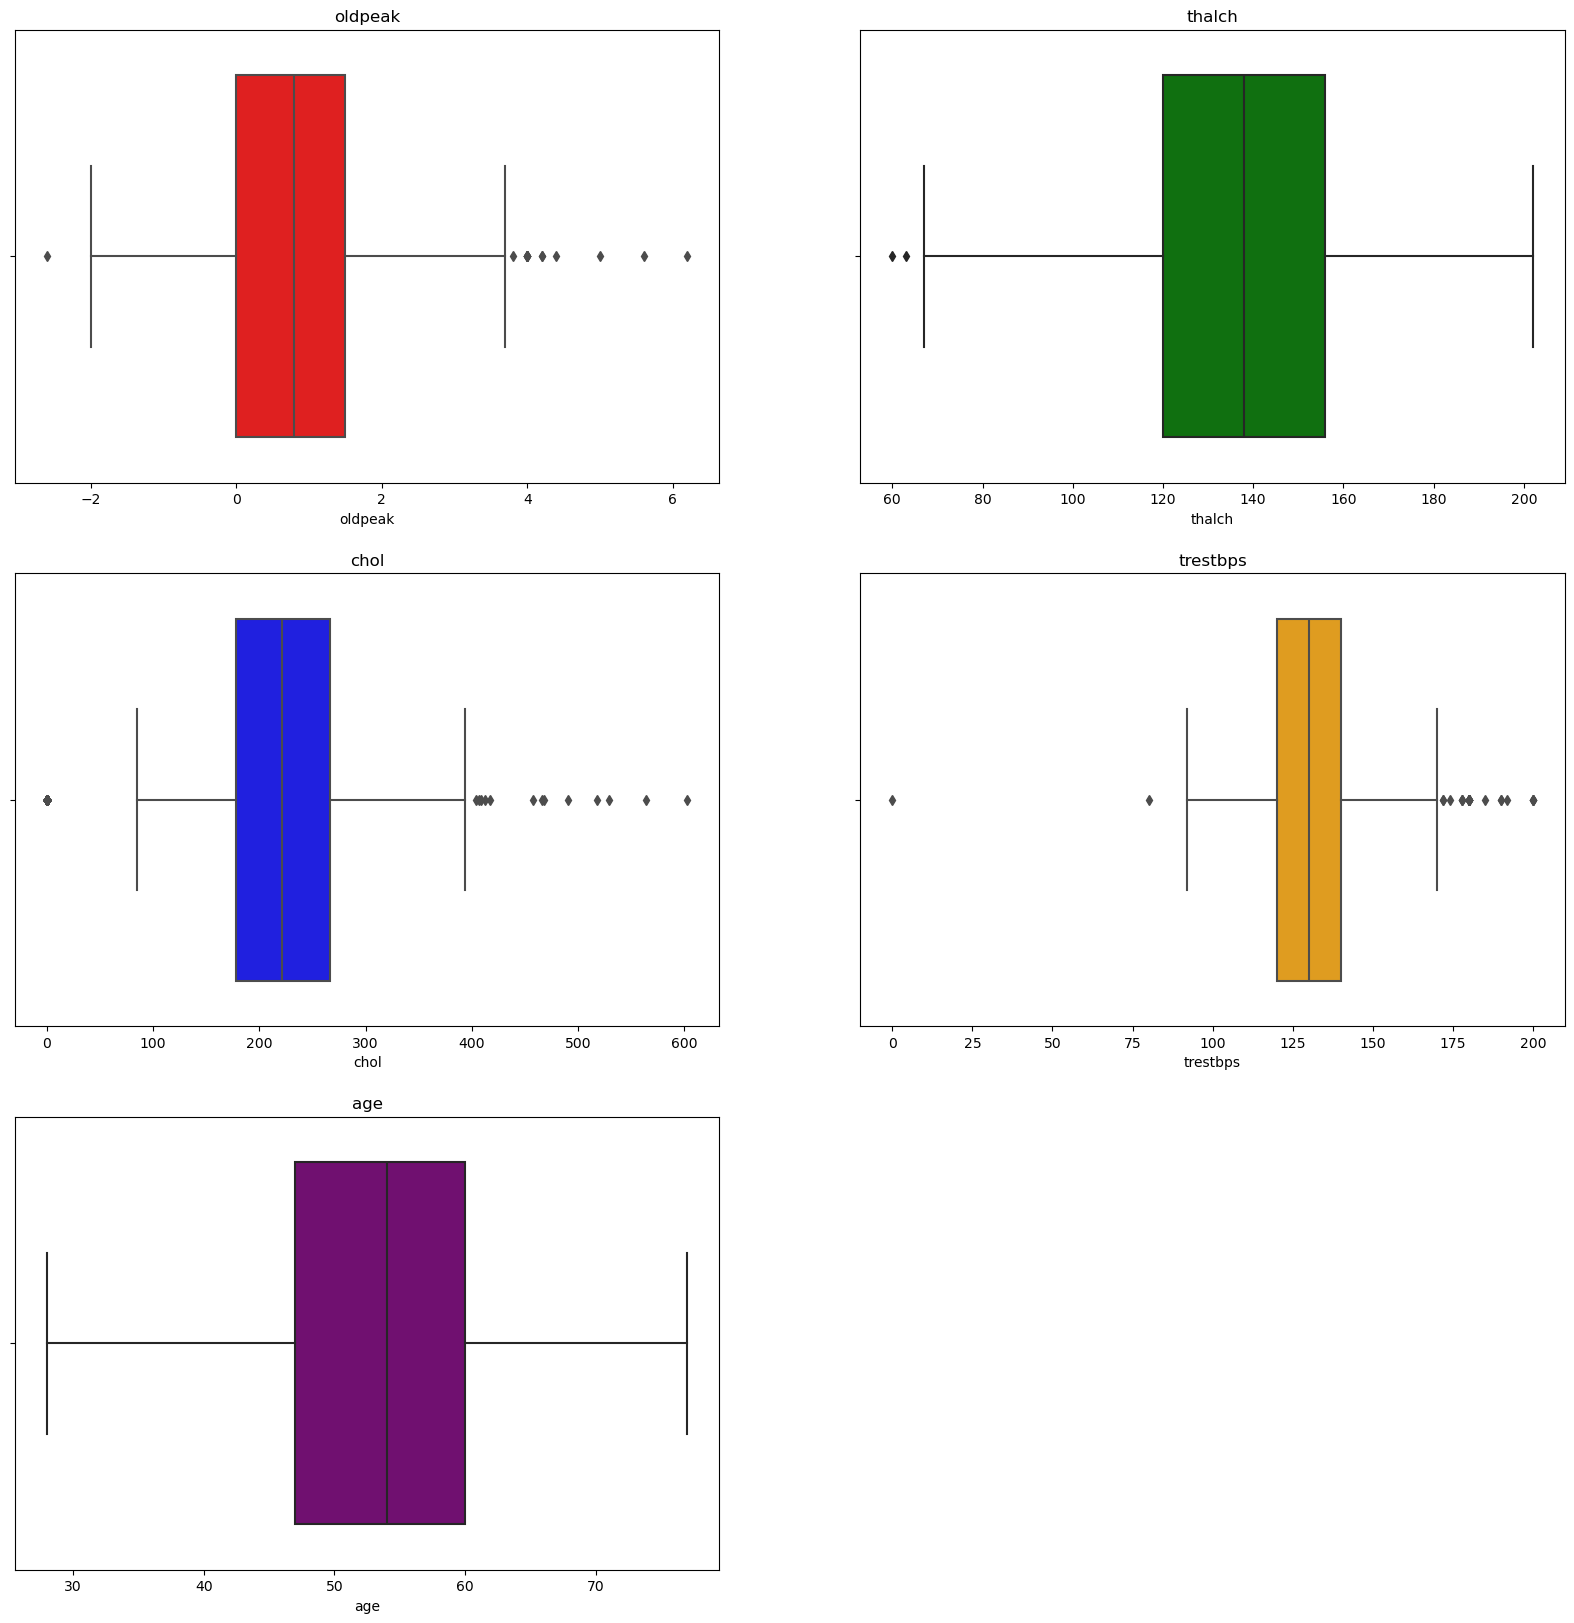

In [56]:
# create box plots for all numeric columns using for loop and subplot
plt.figure(figsize=(20, 20))

colors = ['red', 'green', 'blue', 'orange', 'purple']

for i, col in enumerate(regressor_cols):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=df[col], color=colors[i])
    plt.title(col)
plt.show()

In [57]:
# make box plots of all the numeric columns using for loop and plotly
fig = px.box(data_frame=df, y='age')
fig.show()

fig = px.box(data_frame=df, y='trestbps')
fig.show()

fig = px.box(data_frame=df, y='chol')
fig.show()

fig = px.box(data_frame=df, y='thalch')
fig.show()

fig = px.box(data_frame=df, y='oldpeak')
fig.show()

## Machine Learning

In [58]:
df['num'].value_counts()

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

In [59]:
X = df.drop('num', axis=1)
y = df['num']
label_encoder = LabelEncoder()

for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype == 'category':
        X[col] = label_encoder.fit_transform(X[col])
    else:
        pass

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [60]:
# import all models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
# from lightgbm import LGBMClassifier

# impot pipeline
from sklearn.pipeline import Pipeline

# import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [61]:
# Create a list of models to evaluate
models = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('Support Vector Machine', SVC(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Ada Boost', AdaBoostClassifier(random_state=42)),
    # ('XG Boost', XGBClassifier(random_state=42)),
    ('Naive Bayes', GaussianNB())
]

best_model = None
best_accuracy = 0.0

# Iterate over the models and evaluate their performance
for name, model in models:
    # Create a pipeline for each model
    pipeline = Pipeline([
        # ('imputer', SimpleImputer(strategy='most_frequent')),
        # ('encoder', OneHotEncoder(handle_unknown='ignore')),
        ('model', model)
    ])
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    
    # Calculate mean accuracy
    mean_accuracy = scores.mean()
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print the performance metrics
    print("Model:", name)
    print("Cross-validation Accuracy:", mean_accuracy)
    print("Test Accuracy:", accuracy)
    print()
    
    # Check if the current model has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

# Retrieve the best model
print("Best Model:", best_model)

# save the best model
import pickle
pickle.dump(best_model, open('heart_disease_model.pkl', 'wb'))

Model: Random Forest
Cross-validation Accuracy: 0.6397529069767443
Test Accuracy: 0.6521739130434783

Model: Gradient Boosting
Cross-validation Accuracy: 0.6304263565891473
Test Accuracy: 0.6268115942028986

Model: Support Vector Machine
Cross-validation Accuracy: 0.5822795542635658
Test Accuracy: 0.5905797101449275

Model: Logistic Regression
Cross-validation Accuracy: 0.5202156007751938
Test Accuracy: 0.5

Model: K-Nearest Neighbors
Cross-validation Accuracy: 0.5869912790697674
Test Accuracy: 0.5797101449275363

Model: Decision Tree
Cross-validation Accuracy: 0.5869428294573643
Test Accuracy: 0.5978260869565217

Model: Ada Boost
Cross-validation Accuracy: 0.5885537790697675
Test Accuracy: 0.5615942028985508

Model: Naive Bayes
Cross-validation Accuracy: 0.5480983527131783
Test Accuracy: 0.572463768115942

Best Model: Pipeline(steps=[('model', RandomForestClassifier(random_state=42))])
